# Experiments

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.game_matchup as gm
import experiments as exp
import qgrid

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Setup

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Utils functions

In [3]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

## Load Dataset

In [4]:
gm_df = gm.load_game_matchup_dataset()

## Experiments

### Setup

In [5]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score

In [6]:
exp.exp_results = []
results_total = []

### Dataset

Usando max_split en TimeSeriesSplit permite dividir el dataset por cantidad de filas por lo que vamos a escoger 
solo las temporadas que tiene la misma cantiadad de partidos.


In [7]:
gm_df.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a qu la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [8]:
df = gm_df[gm_df.SEASON >= 2013]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

Prueba de como seran dividido el dataset usando TimeSeriesSplit

In [9]:
tscv = TimeSeriesSplit(n_splits=seasons_size-1, max_train_size=1230)
X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
print(len(X))
for train_index, test_index in tscv.split(X=X):
    print("dtype: ", type(train_index))
    print("TRAIN:", train_index, "TEST:", test_index)

7380
dtype:  <class 'numpy.ndarray'>
TRAIN: [   0    1    2 ... 1227 1228 1229] TEST: [1230 1231 1232 ... 2457 2458 2459]
dtype:  <class 'numpy.ndarray'>
TRAIN: [1230 1231 1232 ... 2457 2458 2459] TEST: [2460 2461 2462 ... 3687 3688 3689]
dtype:  <class 'numpy.ndarray'>
TRAIN: [2460 2461 2462 ... 3687 3688 3689] TEST: [3690 3691 3692 ... 4917 4918 4919]
dtype:  <class 'numpy.ndarray'>
TRAIN: [3690 3691 3692 ... 4917 4918 4919] TEST: [4920 4921 4922 ... 6147 6148 6149]
dtype:  <class 'numpy.ndarray'>
TRAIN: [4920 4921 4922 ... 6147 6148 6149] TEST: [6150 6151 6152 ... 7377 7378 7379]


### Algorithms 

In [10]:
models = exp.get_models()

### Experiment using 1 season

In [11]:
experiment_name = "1_season"

In [12]:
# TimeSeries Cross validation
train_splits = seasons_size - 1
tscv = TimeSeriesSplit(n_splits=train_splits, max_train_size=1230)
X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
params = (experiment_name, df, models, tscv, train_splits, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment 1_season
KNN
balanced_accuracy: 0.638266173950692 - 0.012388548927403384
precision: 0.6942680356832144 - 0.017505301008140333
recall: 0.724577598245685 - 0.022356353939272176
f1: 0.6504635805593454 - 0.012338489000434457
roc_auc: 0.638266173950692 - 0.012388548927403384
SVM
balanced_accuracy: 0.7023793333572499 - 0.0205945882026663
precision: 0.7482881939852426 - 0.025285553913787593
recall: 0.7679533131391177 - 0.022664541178818668
f1: 0.7120407248956584 - 0.01941594424828661
roc_auc: 0.7023793333572499 - 0.020594588202666284
KSVM
balanced_accuracy: 0.5 - 0.0
precision: 0.583739837398374 - 0.006442800896311838
recall: 1.0 - 0.0
f1: 0.43033425003538295 - 0.007748156942408034
roc_auc: 0.5 - 0.0
NB
balanced_accuracy: 0.5899128794081088 - 0.054987549636554764
precision: 0.7126896373971718 - 0.07520596704245437
recall: 0.5162363379919036 - 0.32392254012995275
f1: 0.5265329123421841 - 0.12070246623500626
roc_auc: 0.5899128794081089 - 0.05498754963655473
DT
balanced_accura

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF
balanced_accuracy: 0.6726206346889972 - 0.017825754462942454
precision: 0.7128152865793476 - 0.028480412547168783
recall: 0.8024131558894148 - 0.045993391514306675
f1: 0.6864779191972626 - 0.015779765383889387
roc_auc: 0.6726206346889972 - 0.017825754462942402
GB
balanced_accuracy: 0.66895461637111 - 0.02055660286971414
precision: 0.7228290184060993 - 0.03343593061076319
recall: 0.7428266108523923 - 0.057610706758488145
f1: 0.6780442804478786 - 0.018209927773185614
roc_auc: 0.66895461637111 - 0.02055660286971409
XGB
balanced_accuracy: 0.6681990980430437 - 0.02724266412295967
precision: 0.7218691716541833 - 0.03603643560577665
recall: 0.7430934493154779 - 0.03730529538888247
f1: 0.6778995161026529 - 0.023135752364255687
roc_auc: 0.6681990980430437 - 0.02724266412295967
LGB
balanced_accuracy: 0.679762546375407 - 0.019984287665001575
precision: 0.731579411813026 - 0.025775272713352716
recall: 0.7436805047203902 - 0.02881858754670766
f1: 0.6891270827853159 - 0.018377332730901755
roc_auc

#### Visualize experiments results

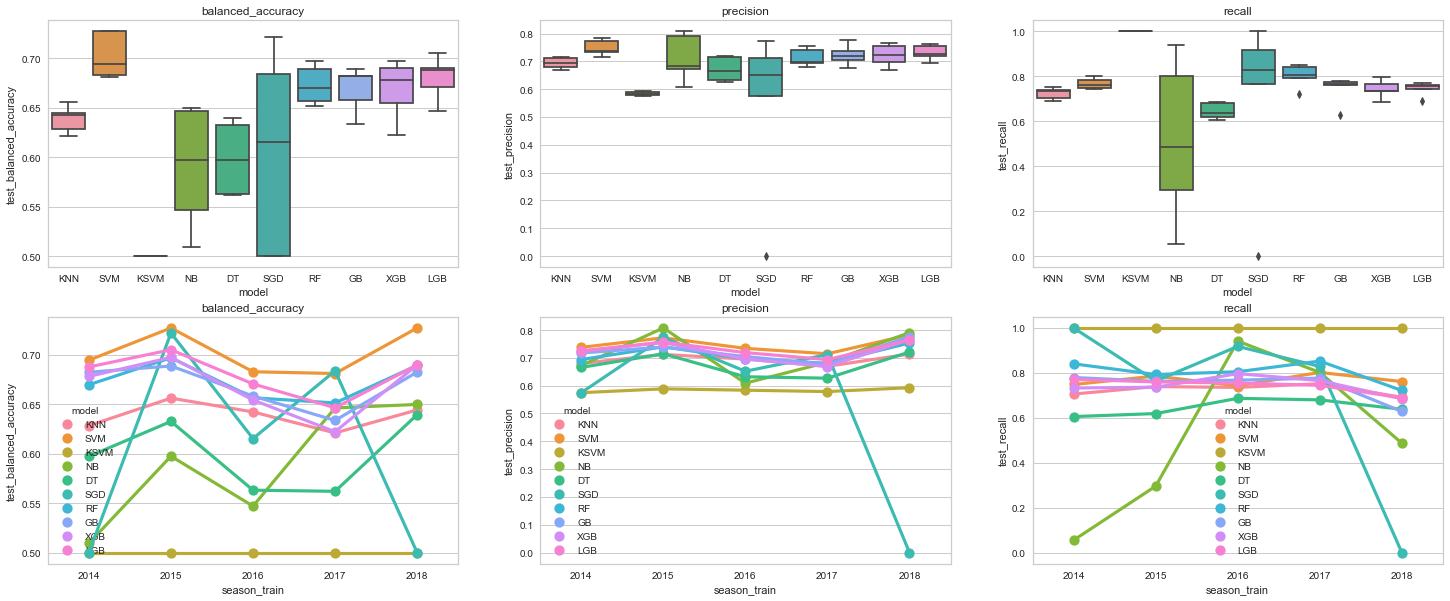

In [13]:
results_df = exp.plot_experiment_results(experiment_name, results)
results_df.to_pickle(f"./experiments/{experiment_name}_exp.pkl")

Se observa lo siguiente:

- KSVM: siempre predice true o 1, por esta razon en los graficos podemos ver como para la metrica test_balanced_accuracy mantiene un rendimiento constante de 50%, y sin embargo para la metrica test_recall observamos como muestra tambien un rendimiento constante de 100% acierto, dado que el modelo nunca produce falsos negativos.

- Se observa como los algoritmos mas estables

https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

### Experiment using StandardScaler

In [14]:
experiment_name = "scaled_data"

In [15]:
train_splits = seasons_size - 1
tscv = TimeSeriesSplit(n_splits=train_splits, max_train_size=1230)
X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
names, results = exp.run_experiment(experiment_name, df, models, tscv, train_splits, X, y, True)
results_total.append((experiment_name, results))

Running experiment scaled_data
KNN
balanced_accuracy: 0.6754298375027097 - 0.01928777264171135
precision: 0.7231651247616558 - 0.025607151150325504
recall: 0.7673378201765793 - 0.04960421218990976
f1: 0.6873606496684703 - 0.015398827658807769
roc_auc: 0.6754298375027097 - 0.01928777264171131
SVM
balanced_accuracy: 0.6531617747424621 - 0.07899025362583809
precision: 0.7101763458443928 - 0.06225331844944021
recall: 0.8020006303000047 - 0.099097445715703
f1: 0.6487460297251312 - 0.10526995497904437
roc_auc: 0.6531617747424618 - 0.07899025362583809
KSVM
balanced_accuracy: 0.5 - 0.0
precision: 0.583739837398374 - 0.006442800896311838
recall: 1.0 - 0.0
f1: 0.43033425003538295 - 0.007748156942408034
roc_auc: 0.5 - 0.0
NB
balanced_accuracy: 0.5590693577229467 - 0.05445478110777875
precision: 0.6731920003478212 - 0.07472579176197316
recall: 0.6185823199078793 - 0.3769352404986154
f1: 0.4901341801595132 - 0.11401163468392114
roc_auc: 0.5590693577229467 - 0.054454781107778766
DT
balanced_accuracy

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF
balanced_accuracy: 0.672157524455305 - 0.01738358898991774
precision: 0.711476113768685 - 0.025276926904617428
recall: 0.8039928850864069 - 0.036965374435656
f1: 0.686671169733639 - 0.015904204292415458
roc_auc: 0.672157524455305 - 0.01738358898991772
GB
balanced_accuracy: 0.6600822404895346 - 0.02364539455991302
precision: 0.7070619734664065 - 0.02718436163970956
recall: 0.776905899431968 - 0.045761254608547595
f1: 0.6737491992485507 - 0.019460481184579183
roc_auc: 0.6600822404895345 - 0.023645394559912943
XGB
balanced_accuracy: 0.6662570033878855 - 0.027521875847614594
precision: 0.71696848618972 - 0.028088611500583536
recall: 0.747989654833211 - 0.030973084344041016
f1: 0.6779144302949291 - 0.026560345619116292
roc_auc: 0.6662570033878855 - 0.027521875847614636
LGB
balanced_accuracy: 0.6851188491240783 - 0.019733629287963083
precision: 0.7347148215571792 - 0.02481062014172969
recall: 0.7509461477884398 - 0.010711774876539966
f1: 0.6950581412467338 - 0.01865787996320996
roc_auc: 0

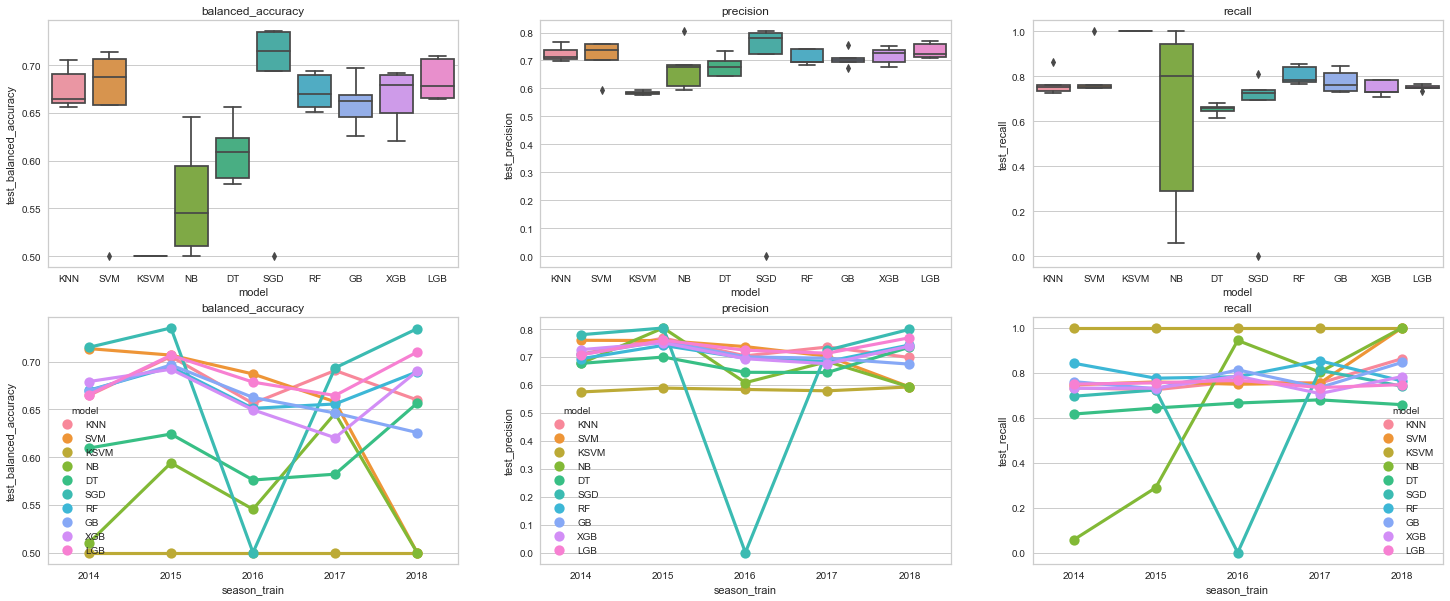

In [16]:
results_df = exp.plot_experiment_results(experiment_name, results)
results_df.to_pickle(f"./experiments/{experiment_name}_exp.pkl")

A partir de realizar los siguientes experimentos:

- Entrenar los modelos sin escalar los valores numericos.

### Experiment using 2 seasons

Usando TimeSeriesSplit visualizaremos como sera dividido el modelo

In [17]:
experiment_name = "2_seasons"

In [18]:
train_splits = seasons_size - 4
tscv = TimeSeriesSplit(n_splits=train_splits, max_train_size=2460)
X, y = train.X_y_values(df, model_config.X_ordinal_cols + model_config.X_num_cols, model_config.y_columns[-1:])
print(len(X))
for train_index, test_index in tscv.split(X=X):
    print("TRAIN:", train_index, "TEST:", test_index)
    
names, results = exp.run_experiment(experiment_name, df, models, tscv, train_splits, X, y)
results_total.append((experiment_name, results))

7380
TRAIN: [   0    1    2 ... 2457 2458 2459] TEST: [2460 2461 2462 ... 4917 4918 4919]
TRAIN: [2460 2461 2462 ... 4917 4918 4919] TEST: [4920 4921 4922 ... 7377 7378 7379]
Running experiment 2_seasons
KNN
balanced_accuracy: 0.6496744452376364 - 0.009012191146560378
precision: 0.7036871158354128 - 0.010889155351027857
recall: 0.7426332653487475 - 0.01170400043890002
f1: 0.66314526459466 - 0.007144106124186256
roc_auc: 0.6496744452376364 - 0.009012191146560489
SVM
balanced_accuracy: 0.7080086988220764 - 0.005254505252160202
precision: 0.7536408029651273 - 0.01845561777994209
recall: 0.7797595386159827 - 0.0467498298781186
f1: 0.7183284051939709 - 0.00043714989890719647
roc_auc: 0.7080086988220764 - 0.0052545052521601465
KSVM
balanced_accuracy: 0.5 - 0.0
precision: 0.5859756097560975 - 0.00020325203252030688
recall: 1.0 - 0.0
f1: 0.4330046812078715 - 0.0002448927025267833
roc_auc: 0.5 - 0.0
NB
balanced_accuracy: 0.5550701576475352 - 0.036805305022524715
precision: 0.6707800724486822 - 

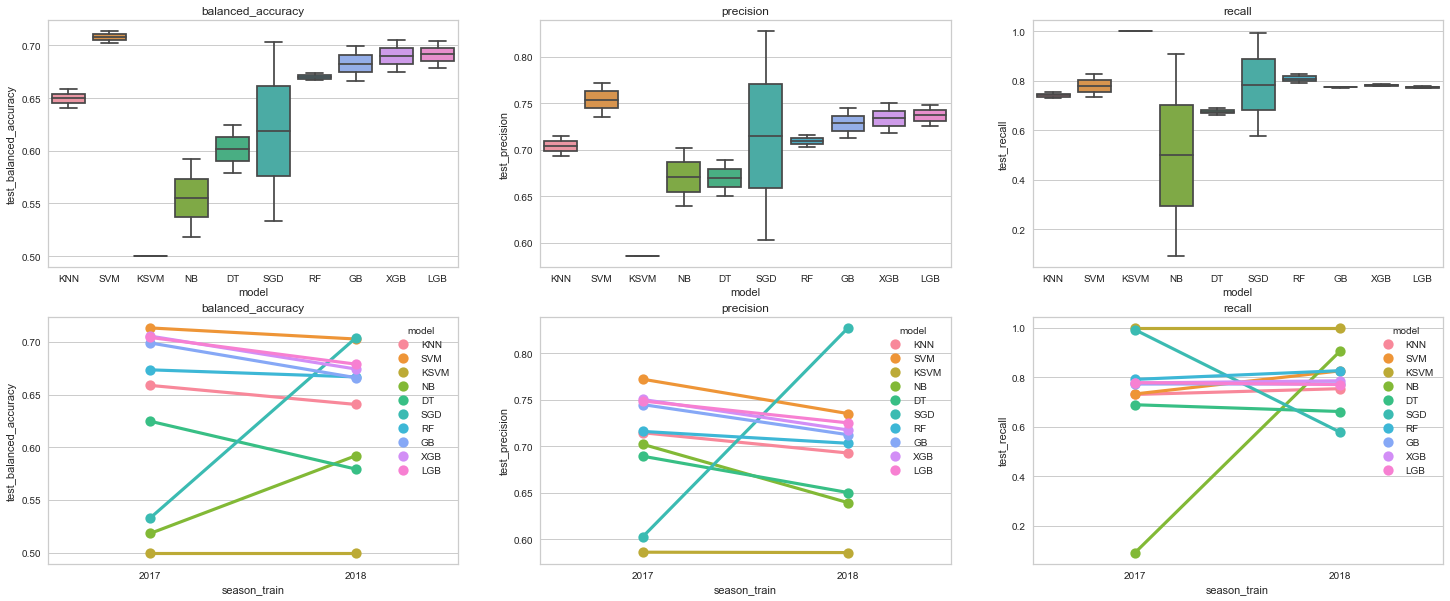

In [19]:
results_df = exp.plot_experiment_results(experiment_name, results)
results_df.to_pickle(f"./experiments/{experiment_name}_exp.pkl")

### Experiment quarter split

In [20]:
experiment_name = "4_quarter_pred"

In [21]:
result_size = (seasons_size - 1) * 4
tscv = utils.CustomTimeSeriesSplit(df)
X, y = train.X_y_values(df, model_config.X_ordinal_cols + model_config.X_num_cols, model_config.y_columns[-1:])
    
names, results = exp.run_experiment(experiment_name
                                    , df
                                    , models
                                    , list(tscv.split(1))
                                    , (result_size, seasons[-(seasons_size - 1):])
                                    , X, y
                                    , False
                                    , (True, [0.25, 0.5, 0.75, 1]))
results_total.append((experiment_name, results))

Running experiment 4_quarter_pred
KNN
balanced_accuracy: 0.6428449860337861 - 0.03819899545036296
precision: 0.6990137784524788 - 0.03496791631005727
recall: 0.7230976690998571 - 0.0485843348305836
f1: 0.6545794477462147 - 0.03589670075522597
roc_auc: 0.6428449860337861 - 0.038198995450362955
SVM
balanced_accuracy: 0.6988972813315297 - 0.08004878330479265
precision: 0.7461979230884308 - 0.06670927902665139
recall: 0.7845938277297103 - 0.06486604470986622
f1: 0.710976943361177 - 0.07465347867646392
roc_auc: 0.6988972813315297 - 0.08004878330479265
KSVM
balanced_accuracy: 0.5 - 0.0
precision: 0.5837281610897247 - 0.024208529414714505
recall: 1.0 - 0.0
f1: 0.43059740049412937 - 0.02891846539640743
roc_auc: 0.5 - 0.0
NB
balanced_accuracy: 0.6117160692048044 - 0.06487544322948632
precision: 0.7062261440639872 - 0.19013179534915517
recall: 0.5503548413923325 - 0.2970126382668474
f1: 0.5639593585787838 - 0.14169532217283626
roc_auc: 0.6117160692048044 - 0.06487544322948632


/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DT
balanced_accuracy: 0.606572262002103 - 0.0549715617611509
precision: 0.6777691899349689 - 0.05264389183821738
recall: 0.6565189532083572 - 0.05946616686776243
f1: 0.6151892384245408 - 0.05104776195217991
roc_auc: 0.6065722620021028 - 0.05497156176115091


/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SGD
balanced_accuracy: 0.590806381624647 - 0.09075669039118213
precision: 0.6828908452190192 - 0.20909407417171336
recall: 0.7236136526902374 - 0.3396372861352773
f1: 0.533893191425029 - 0.1470521851980942
roc_auc: 0.590806381624647 - 0.09075669039118213
RF
balanced_accuracy: 0.6774931172470299 - 0.04494840437484193
precision: 0.7164805302826471 - 0.03797212457933601
recall: 0.8063180678659432 - 0.04290889980483369
f1: 0.6930807979014323 - 0.04128567874582318
roc_auc: 0.6774931172470299 - 0.04494840437484192
GB
balanced_accuracy: 0.675776488576046 - 0.045775170854097484
precision: 0.7255525295024757 - 0.04148723154869737
recall: 0.7565429914115012 - 0.05520084612595656
f1: 0.6872665601187525 - 0.04291001529741138
roc_auc: 0.675776488576046 - 0.0457751708540975
XGB
balanced_accuracy: 0.6761689702059548 - 0.053678780346590196
precision: 0.727442108633824 - 0.045649995418274567
recall: 0.7567903527712299 - 0.05248427159080585
f1: 0.6881281659983107 - 0.05026557349121051
roc_auc: 0.6761689

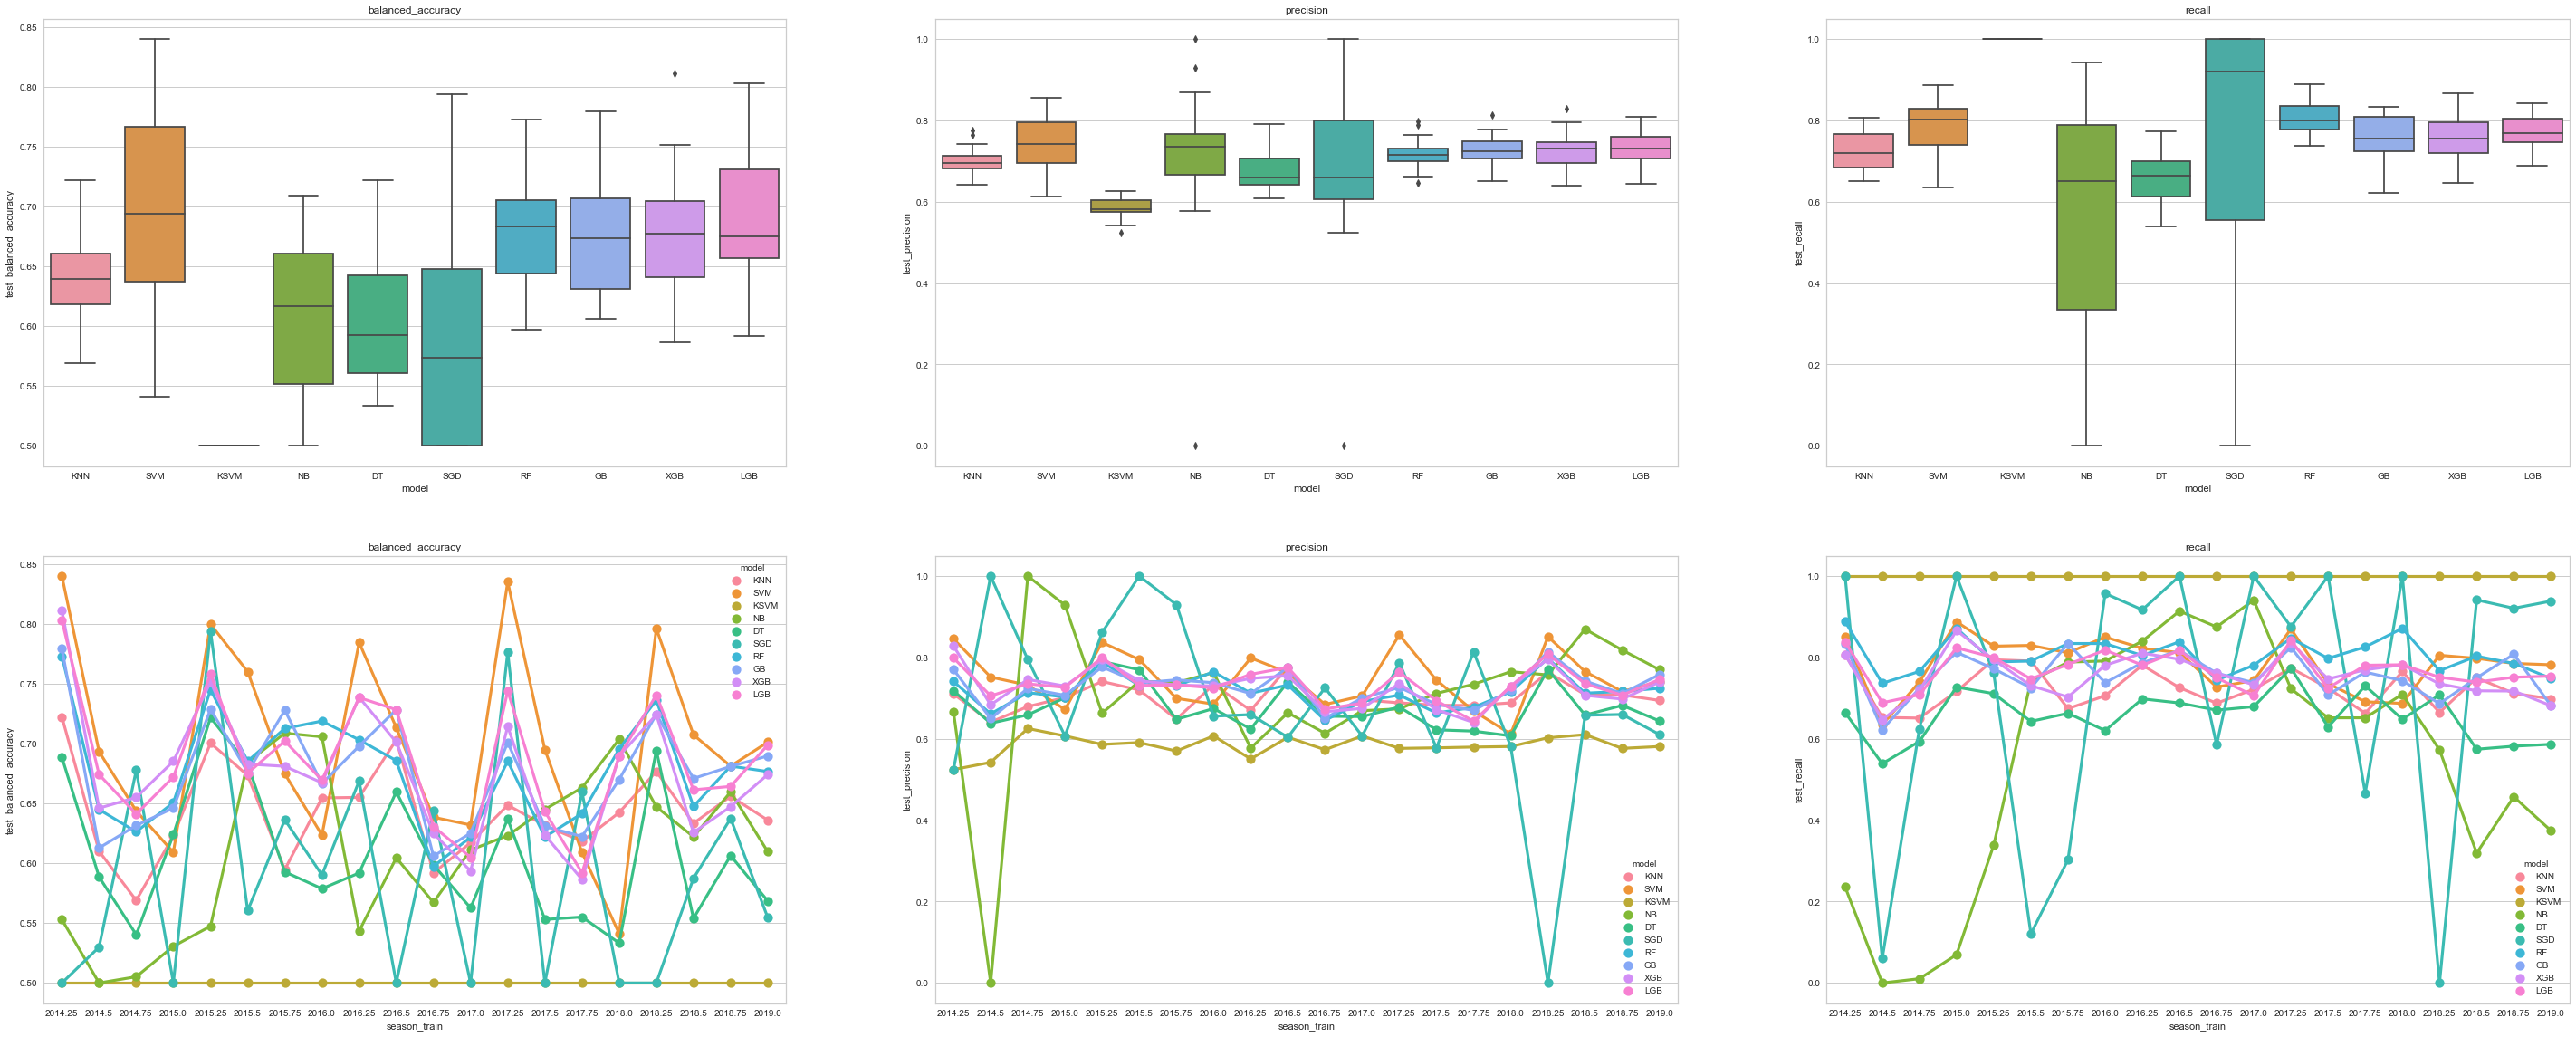

In [22]:
results_df = exp.plot_experiment_results(experiment_name, results, figsize=(50, 20))
results_df.to_pickle(f"./experiments/{experiment_name}_exp.pkl")

### Experiment 2 quarter split

In [23]:
experiment_name = "2_quarter_pred"

In [24]:
result_size = (seasons_size - 1) * 2
tscv = utils.CustomTimeSeriesSplit(df)
X, y = train.X_y_values(df, model_config.X_ordinal_cols + model_config.X_num_cols, model_config.y_columns[-1:])
#for train_index, test_index in tscv.split(1):
    #print("TRAIN:", len(train_index), "TEST:", len(test_index))
    #print("TRAIN:", train_index[:5], "TEST:", test_index[:5])
    
names, results = exp.run_experiment(experiment_name
                                    , df
                                    , models
                                    , list(tscv.split(1, [0.5, 1]))
                                    , (result_size, seasons[-(seasons_size - 1):])
                                    , X, y
                                    , False
                                    , (True, [0.5, 1]))
results_total.append((experiment_name, results))

Running experiment 2_quarter_pred
KNN
balanced_accuracy: 0.6395926006161006 - 0.03015269580475439
precision: 0.6958733439660257 - 0.022680283940824417
recall: 0.7226746470755969 - 0.03818305757438029
f1: 0.651807934087244 - 0.027757334828440013
roc_auc: 0.6395926006161006 - 0.03015269580475438
SVM
balanced_accuracy: 0.6956446650904742 - 0.07090038411609352
precision: 0.7442557767690418 - 0.06160306986140716
recall: 0.7745985305423716 - 0.04564778511162749
f1: 0.7069692610544678 - 0.06497579813418386
roc_auc: 0.6956446650904742 - 0.07090038411609352
KSVM
balanced_accuracy: 0.5 - 0.0
precision: 0.583739837398374 - 0.02079775864106598
recall: 1.0 - 0.0
f1: 0.4305338977084709 - 0.024803264755910923
roc_auc: 0.5 - 0.0
NB
balanced_accuracy: 0.6052630637366208 - 0.06314673860593062
precision: 0.7334398394163965 - 0.08812088325141922
recall: 0.5430118112335933 - 0.30769672685342686
f1: 0.5537283612390708 - 0.1339631285104474
roc_auc: 0.6052630637366208 - 0.0631467386059306
DT
balanced_accuracy

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SGD
balanced_accuracy: 0.638815185286102 - 0.08002841108634466
precision: 0.6683727117371948 - 0.24365030244607946
recall: 0.6424048209406461 - 0.2966222082401065
f1: 0.5872585664157961 - 0.1597926503547305
roc_auc: 0.6388151852861021 - 0.08002841108634466
RF
balanced_accuracy: 0.6736154787140272 - 0.03023486768805281
precision: 0.712273111938016 - 0.03263713654457812
recall: 0.8087143925926471 - 0.039751312351449165
f1: 0.6884913195360743 - 0.02678898144348114
roc_auc: 0.6736154787140272 - 0.030234867688052783
GB
balanced_accuracy: 0.6706935936701163 - 0.03257472436045391
precision: 0.7195580995227896 - 0.036571725409208417
recall: 0.7618783098214065 - 0.04378294224389217
f1: 0.6823352860019638 - 0.029290473359008293
roc_auc: 0.670693593670116 - 0.032574724360453895
XGB
balanced_accuracy: 0.6731577958326653 - 0.041906361392279184
precision: 0.7228759221777001 - 0.041106807048427646
recall: 0.7612453538620152 - 0.029293475070304102
f1: 0.6847943704647378 - 0.037745411801223594
roc_auc:

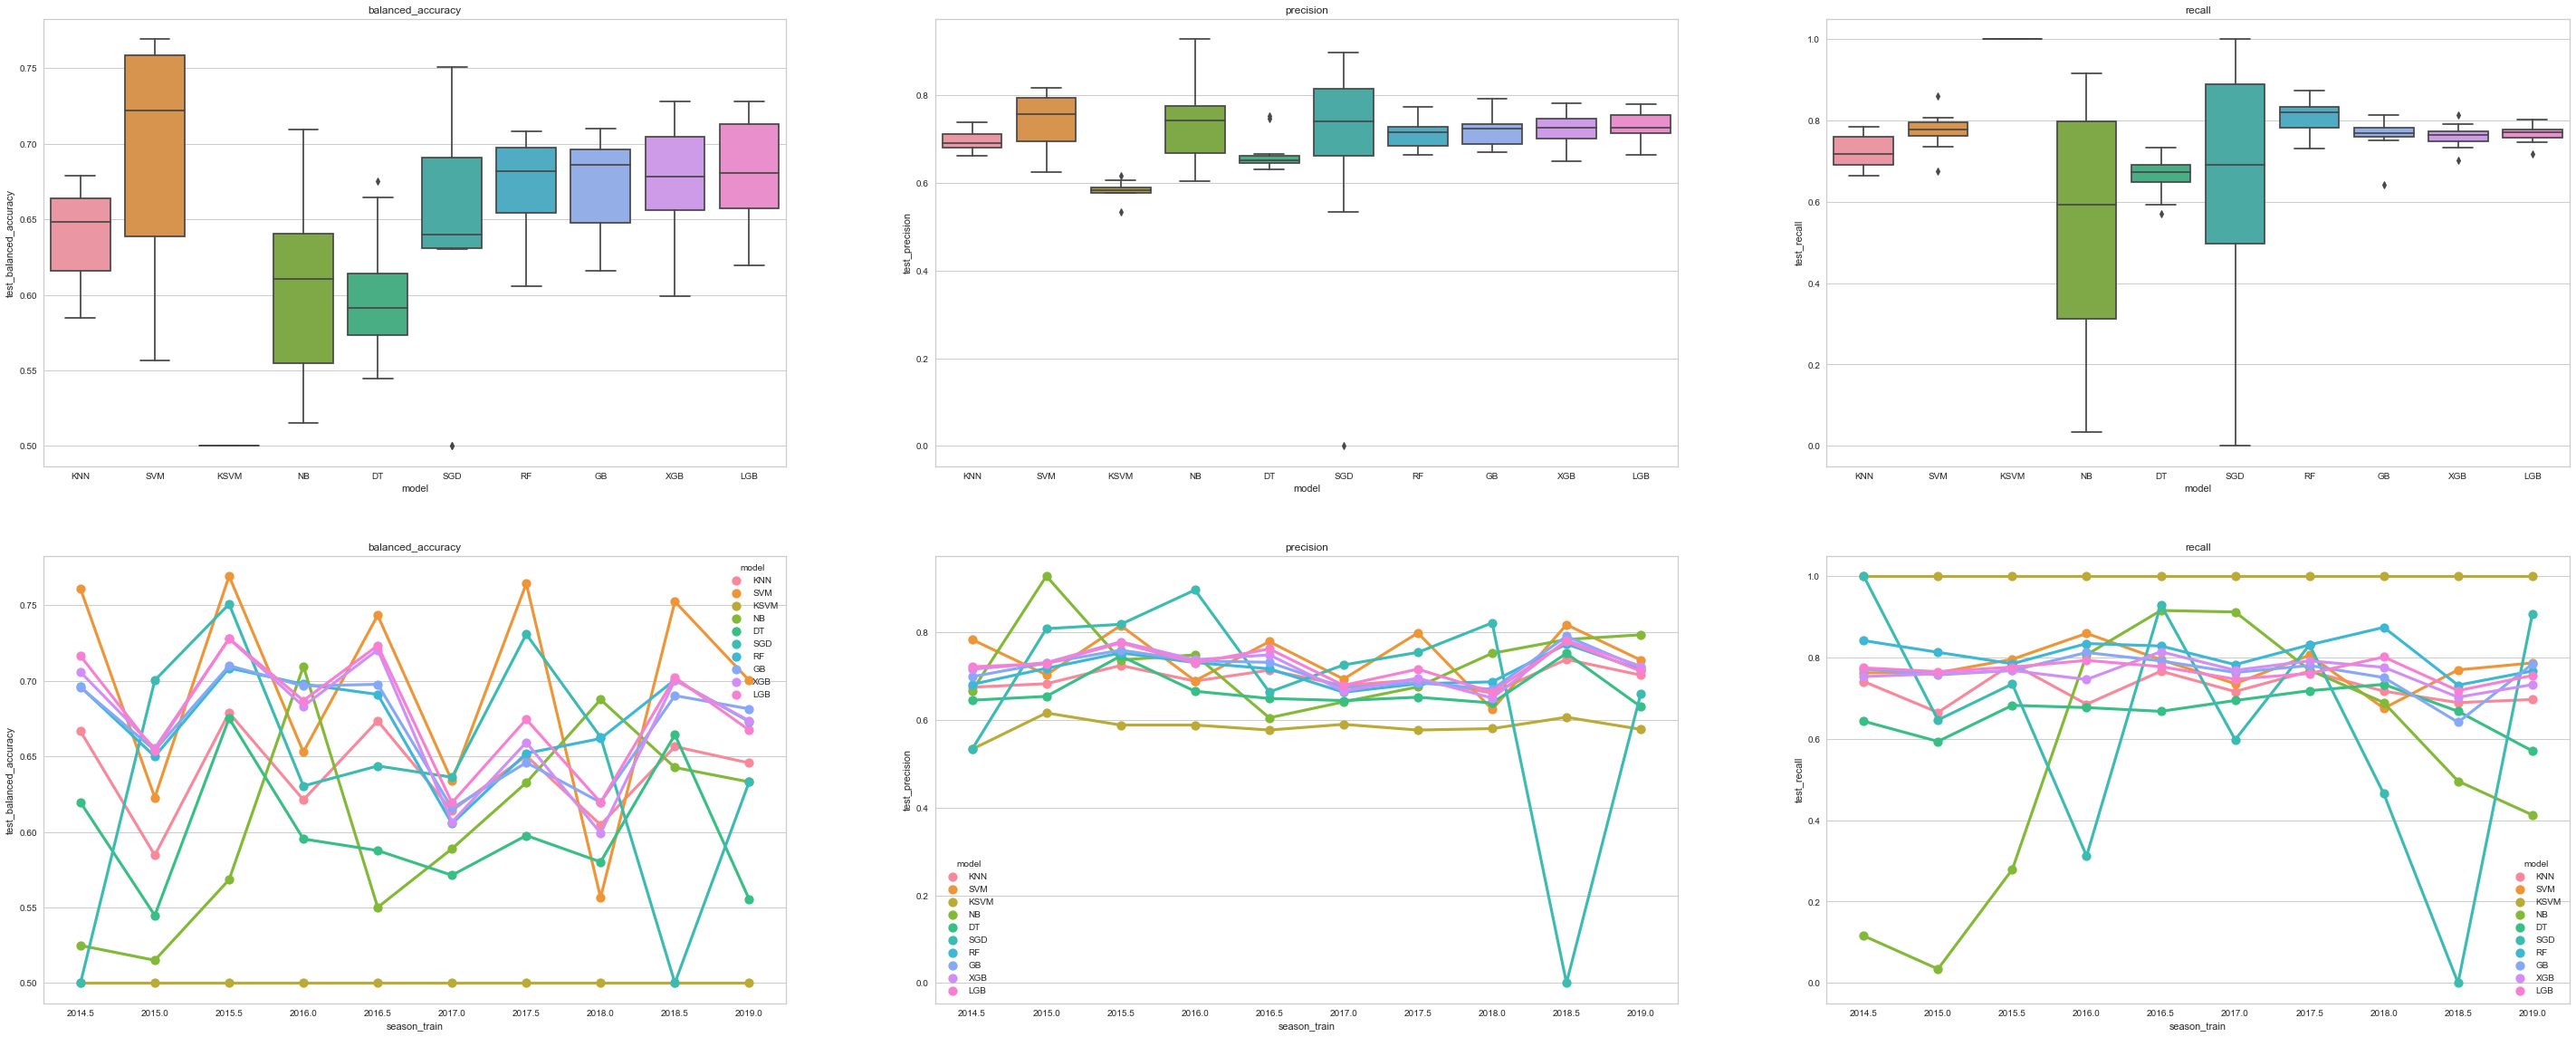

In [25]:
results_df = exp.plot_experiment_results(experiment_name, results, figsize=(50, 20))
results_df.to_pickle(f"./experiments/{experiment_name}_exp.pkl")

## Experiments comparison

In [26]:
exp_df = pd.DataFrame(exp.exp_results)

In [40]:
exp_df_sorted = exp_df[['exp_name', 'model',
       'balanced_accuracy_mean', 'balanced_accuracy_std']]

In [41]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(exp_df_sorted, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

Se observa:

    - KSVM: Es un modelo que se va a descartar ya que solo predice true a todas las instancias. Por esta razon podemos ver como el algoritmo obtuvo un 0.0 de desviacion estandar, ya que no dio ningun falso negativo.

    - Random Forest es el modelo que se presenta mas estable.
    
        Cuando se evaluo con el dataset de dos temporadas obtuvo la mejor desviacion estandar.
    
    - Las tecnicas de normalizacion de features no mostraron cambios significativos, comparados con los experimentos no normalizados.
    
    

## Plot experiment results

In [29]:
utils.serialize_object("results", exp.exp_results)
utils.serialize_object("results_total", results_total)

### Balance Accuracy

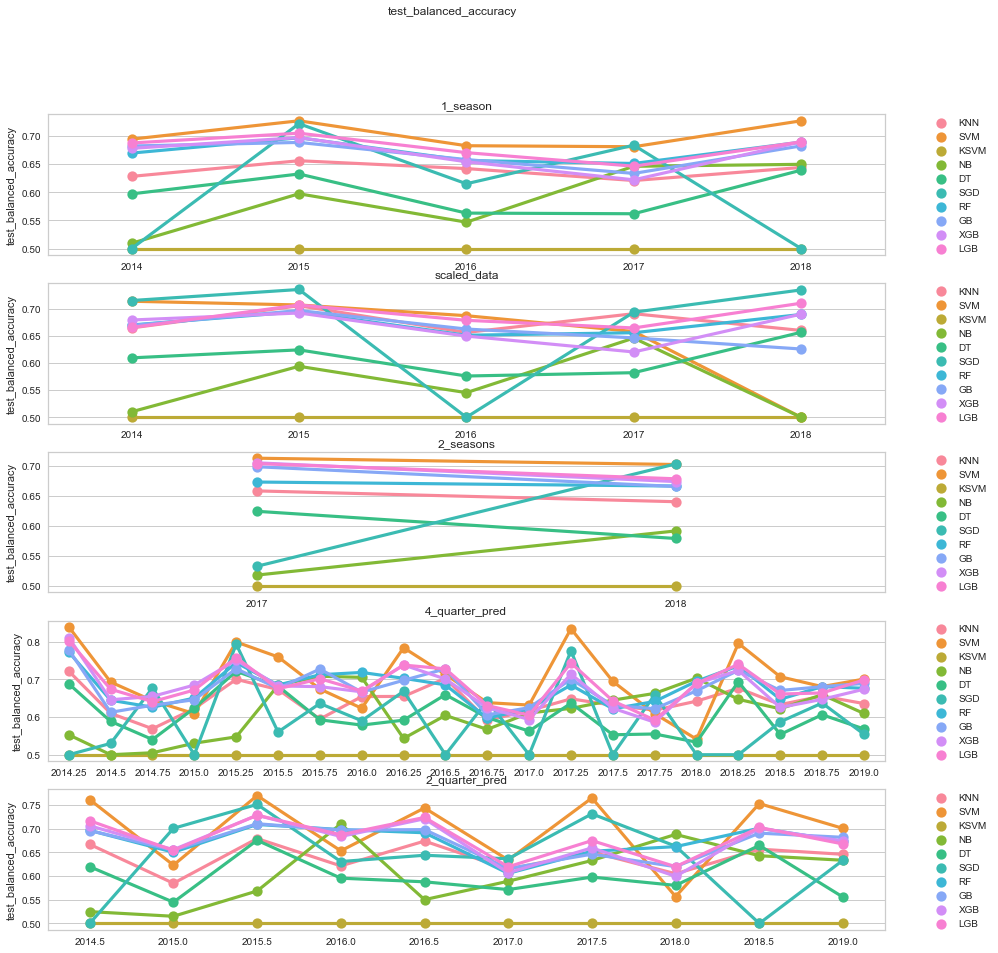

In [30]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_balanced_accuracy", 
    figsize=(15, 15),
    use_pointplot=True
)

### Precision

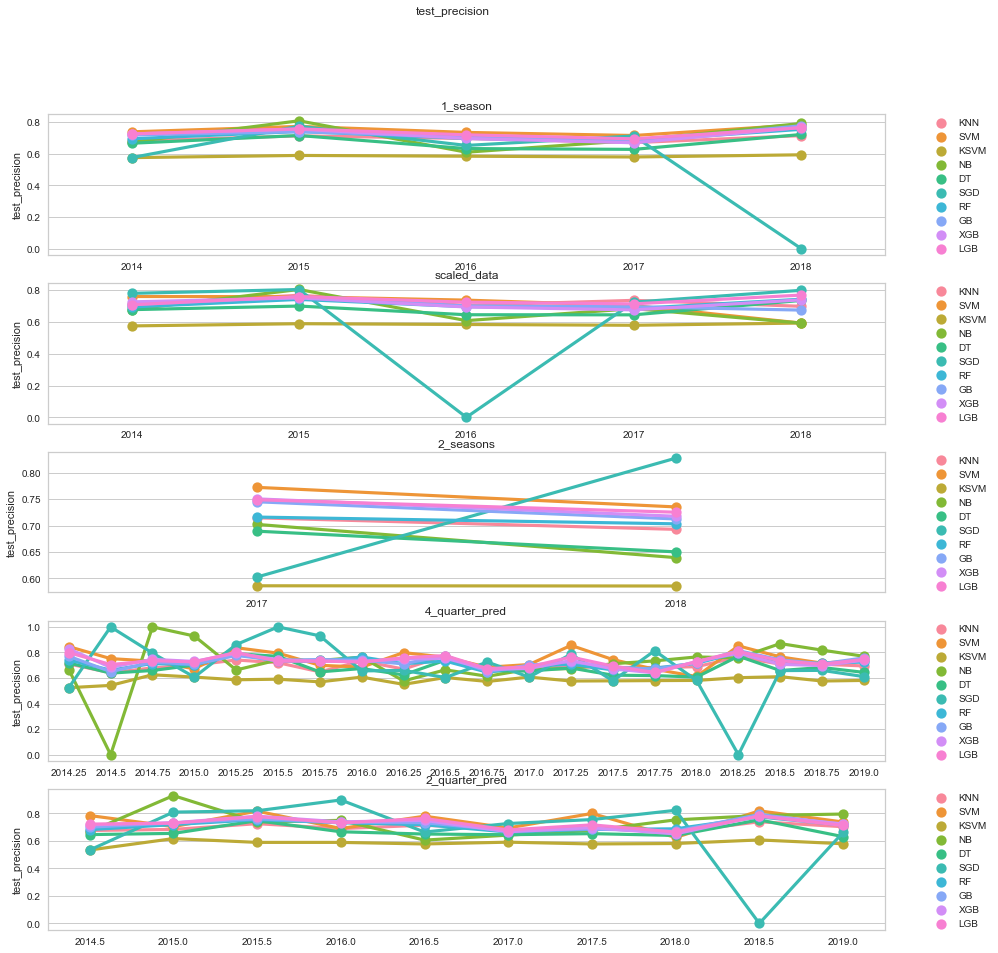

In [31]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_precision", 
    figsize=(15, 15),
    use_pointplot=True
)

### Recall

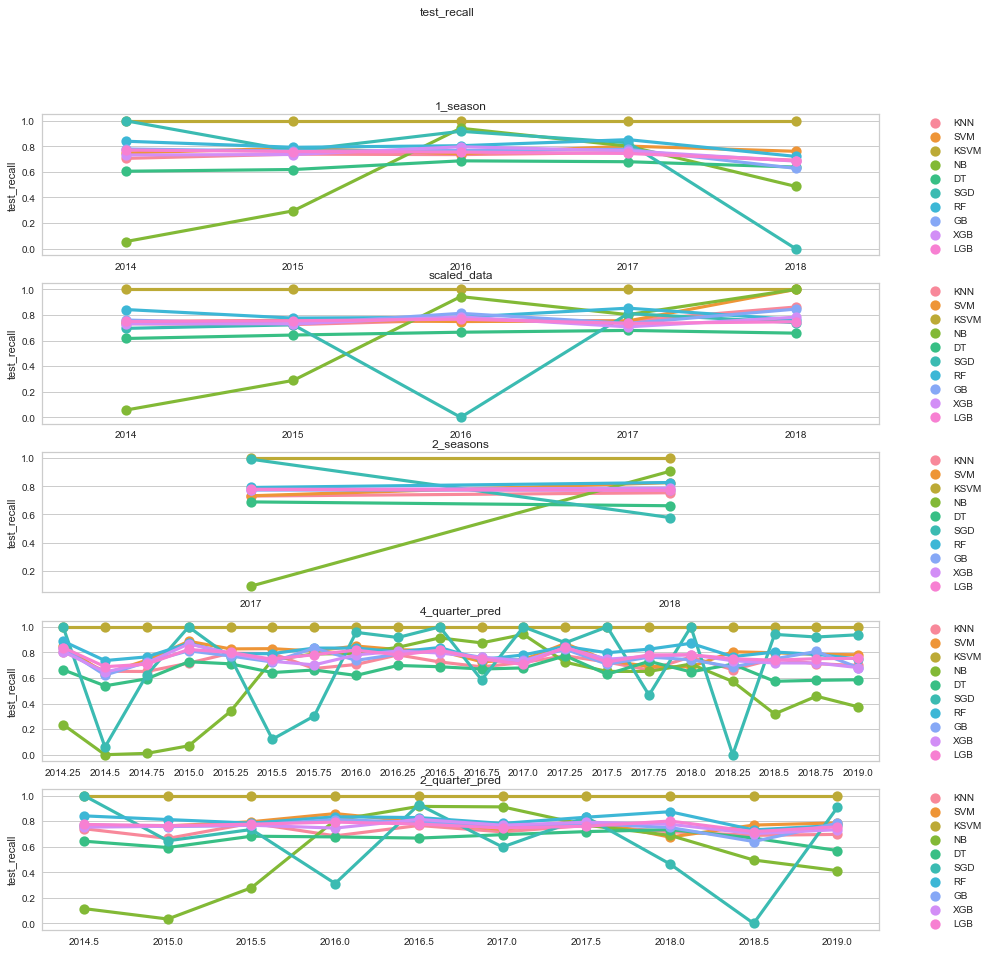

In [32]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_recall", 
    figsize=(15, 15),
    use_pointplot=True
)

### F1

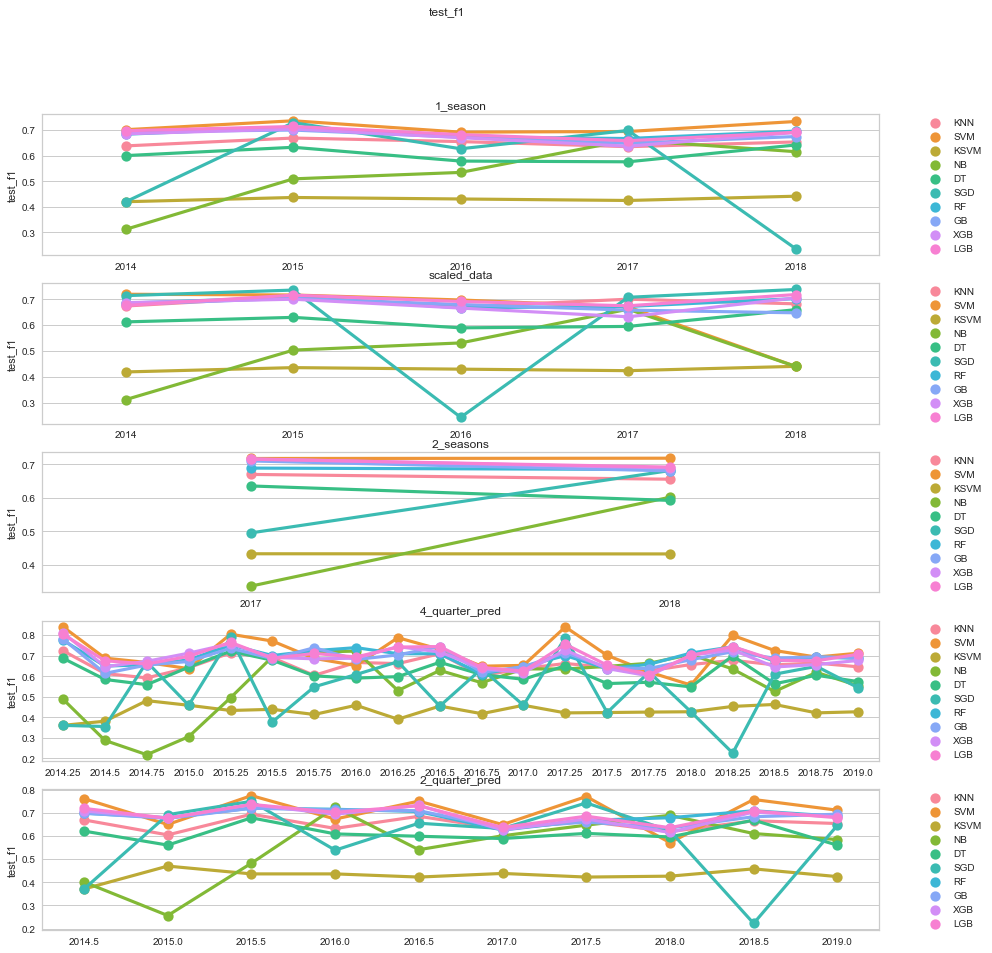

In [33]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_f1", 
    figsize=(15, 15),
    use_pointplot=True
)

### ROC AUC

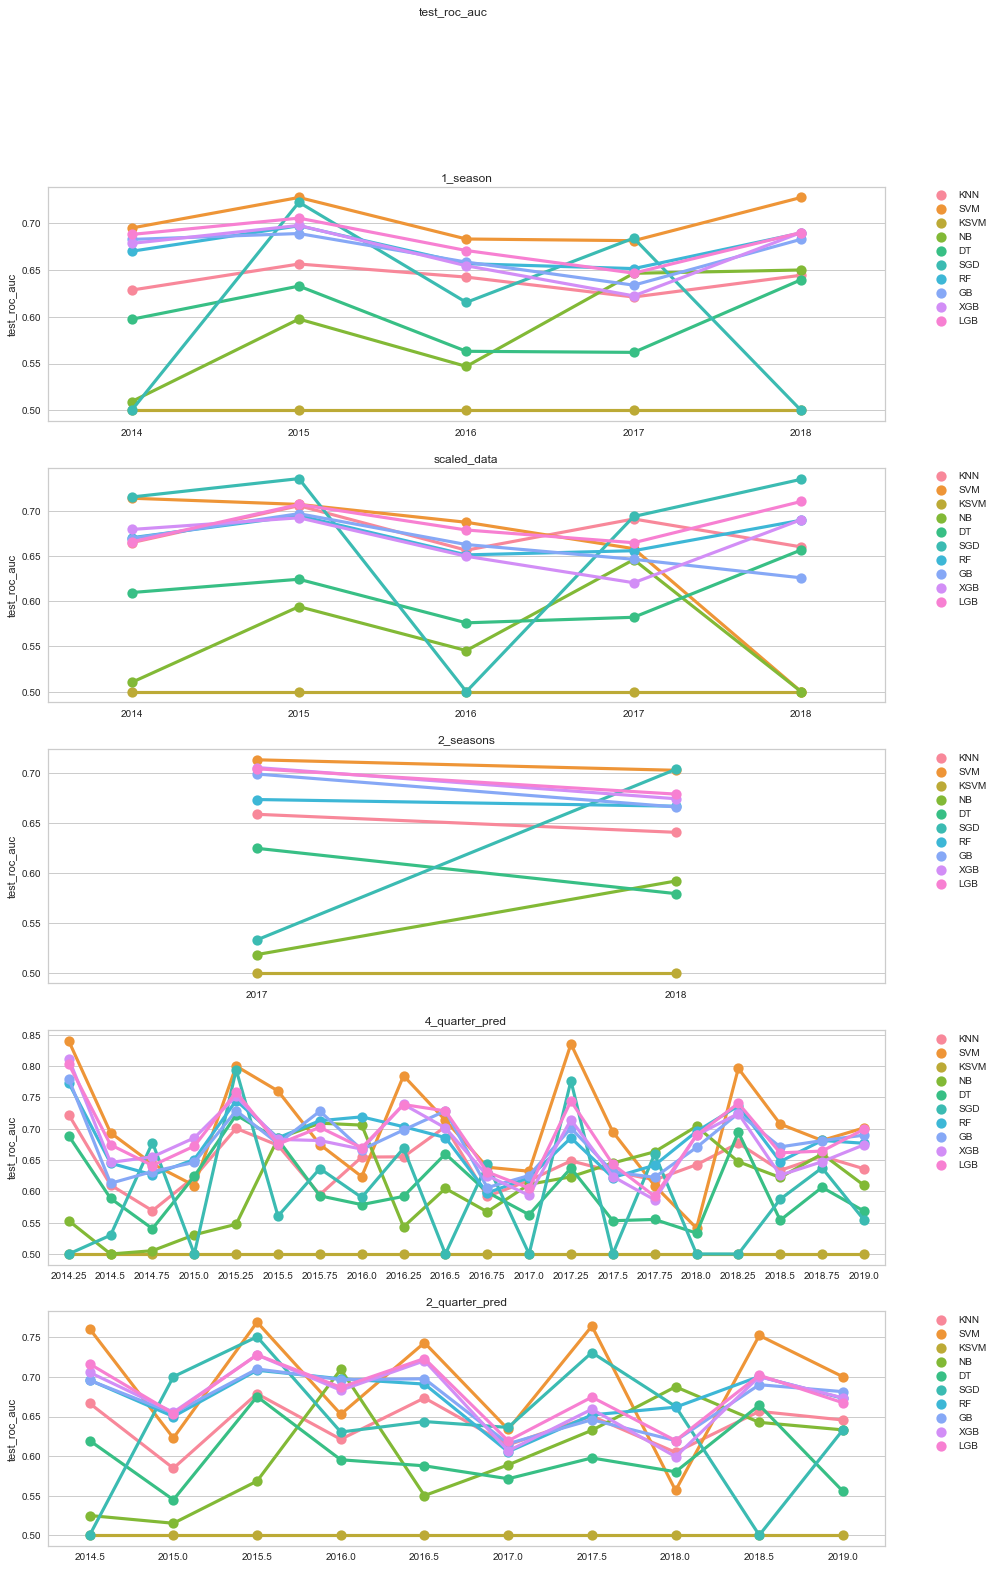

In [34]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_roc_auc", 
    figsize=(15, 25),
    use_pointplot=True
)

## Test a specific model

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

tscv = TimeSeriesSplit(n_splits=len(df.SEASON.unique())-1, max_train_size=1230)
X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
model = SVC(kernel = 'rbf', random_state=0)
for train_index, test_index in tscv.split(X=X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    model.fit(X[train_index], y[train_index].ravel())
    predictions = model.predict(X=X[test_index])
    percentage = model.score(X[test_index], y[test_index].ravel())
    res = confusion_matrix(y[test_index], predictions)
    print("Confusion Matrix")
    print(res)
    print(f"Test Set: {len(X[test_index])}")
    print(f"Accuracy = {percentage*100} %")
    print(f"balanced_accuracy_score: {balanced_accuracy_score(y[test_index], predictions)}")
    print(f"recall_score: {recall_score(y[test_index], predictions)}")
    # Show confusion matrix in a separate window
    plt.matshow(res)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

results_pred = np.concatenate((predictions.reshape(len(predictions),1), y[test_index].reshape(len(y[test_index]),1)),1)
test_pred = pd.DataFrame(results_pred, columns=["pred", "true"])